# ELEC0134 - Applied Machine Learning Systems Assignment 22-23
## B1: Face Shape Detection

This notebook will create a random forests model to detect gender on the celeba dataset. To create the model the following steps will be followed:

1. Image preprocessing to extract facial landmarks.
2. Normalization of the features.
3. Tuning hyperparameters of SVM model 
4. Training the random forests model 
5. Evaluation of the model

## 1) Preprocessing
### Facial landmark extraction



In [1]:
# Imports 

import os.path
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import imutils
from imutils import face_utils

Uses dlib library's pretrained shape predictor to predict the locations of 668 landmarks on detected faces. 

In [2]:
detector = dlib.get_frontal_face_detector()

# Uses landmark predictor from parent directory
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [3]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [4]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [5]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

In [13]:
def extract_features_labels(images_dir, labels_dir, name):
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extracts the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        shape_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(labels_dir, 'r')
    print('labels_file ', labels_file)
    lines = labels_file.readlines()
    shape_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    counter = 0
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        fails = []

        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('/')[-1]

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(shape_labels[file_name])
            else: 
                fails.append(file_name)
            counter += 1
            print(counter)


    landmark_features = np.array(all_features)
    landmark_features = landmark_features.reshape(len(landmark_features), 136)
    shape_labels = np.array(all_labels)

    np.save("all_features_{}.npy".format(name), landmark_features)
    np.save("shape_labels_{}.npy".format(name), shape_labels)

    return landmark_features, shape_labels, fails


In [15]:
train_img = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23/cartoon_set/img'
train_label = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23/cartoon_set/labels.csv'
extract_features_labels(train_img, train_label, 'train')

test_img = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23_test/cartoon_set_test/img'
test_label = '/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23_test/cartoon_set_test/labels.csv'
extract_features_labels(test_img, test_label, 'test')


labels_file  <_io.TextIOWrapper name='/Users/yash/Documents/ELEC0134/AMLS_22-23_SN19076187/Dataset/dataset_AMLS_22-23/cartoon_set/labels.csv' mode='r' encoding='UTF-8'>
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235

(array([[158, 246, 160, ..., 351, 241, 349],
        [170, 270, 169, ..., 376, 242, 377],
        [158, 247, 163, ..., 349, 243, 348],
        ...,
        [157, 248, 161, ..., 350, 240, 348],
        [159, 246, 163, ..., 352, 242, 350],
        [165, 249, 168, ..., 338, 239, 336]]),
 array([1, 4, 3, ..., 0, 3, 2]),
 ['1006',
  '1018',
  '1020',
  '1029',
  '1034',
  '1037',
  '1039',
  '1055',
  '1057',
  '1058',
  '1060',
  '1063',
  '107',
  '1072',
  '1075',
  '1082',
  '1086',
  '1087',
  '1093',
  '1094',
  '1098',
  '1109',
  '1111',
  '1122',
  '1130',
  '1141',
  '1143',
  '1145',
  '1146',
  '1147',
  '1163',
  '1171',
  '1172',
  '1173',
  '1177',
  '118',
  '1180',
  '1183',
  '1199',
  '1200',
  '1201',
  '1204',
  '1215',
  '1225',
  '1229',
  '1236',
  '1238',
  '1240',
  '1242',
  '1251',
  '1252',
  '1256',
  '1266',
  '127',
  '1272',
  '1277',
  '1287',
  '1290',
  '1293',
  '1294',
  '1301',
  '1303',
  '1307',
  '1308',
  '1318',
  '1320',
  '1321',
  '1323',
  '13

In [17]:
# Loading in training and test data from npy files
features_train = np.load('all_features_train.npy')
labels_train = np.load('gender_labels_train.npy')

features_test = np.load('all_features_test.npy')
labels_test = np.load('gender_labels_test.npy')


In [18]:
print('features_train: ', features_train.shape)
print('features_test: ', features_test.shape)
print('labels_train: ', labels_train.shape)
print('labels_test: ', labels_test.shape)

features_train:  (8194, 136)
features_test:  (2041, 136)
labels_train:  (8194,)
labels_test:  (2041,)


Standardize data function

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
def preprocessing(features, test_features):
    
    # Scaling of data, trained on training data and applied to both training and test datasets
    scaler = StandardScaler()
    scaler.fit(features)

    features = scaler.transform(features)
    test_features = scaler.transform(test_features)
    
    return features, test_features

In [21]:
features_train, features_test = preprocessing(features_train, features_test)

In [22]:
print(features_train)

[[-2.12204165  2.57963379 -2.38530623 ... -0.03008722  0.5747203
   0.24404393]
 [ 0.35387169  0.09414611  0.4486405  ...  0.76008812  0.5747203
   0.71474521]
 [-0.63649364 -0.63078779 -0.79121119 ...  0.91812318 -0.62011854
   0.87164564]
 ...
 [ 2.99484592  0.40483207  3.10546556 ...  0.12794784  0.5747203
   0.24404393]
 [ 0.35387169  0.40483207  0.62576217 ...  0.60205305  0.17644069
   0.55784478]
 [ 0.51893258 -0.00941588  0.80288384 ... -0.34615736  0.17644069
  -0.38355778]]


Checking features to decide ranges of hyperparameters to check for tuning

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [26]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [2, 4, 6, 8, 10, 12]}


# rfm = random forest model
rfm = RandomForestClassifier()
#grid_search = RandomizedSearchCV(rfm, param_grid, verbose = 3, cv = 10)
#grid_search.fit(features_train, labels_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END ....max_depth=6, n_estimators=150;, score=0.644 total time=   7.4s
[CV 2/10] END ....max_depth=6, n_estimators=150;, score=0.670 total time=   6.1s
[CV 3/10] END ....max_depth=6, n_estimators=150;, score=0.659 total time=   5.5s
[CV 4/10] END ....max_depth=6, n_estimators=150;, score=0.662 total time=   5.6s
[CV 5/10] END ....max_depth=6, n_estimators=150;, score=0.662 total time=   4.5s
[CV 6/10] END ....max_depth=6, n_estimators=150;, score=0.670 total time=   3.7s
[CV 7/10] END ....max_depth=6, n_estimators=150;, score=0.624 total time=   4.7s
[CV 8/10] END ....max_depth=6, n_estimators=150;, score=0.669 total time=   4.1s
[CV 9/10] END ....max_depth=6, n_estimators=150;, score=0.648 total time=   3.7s
[CV 10/10] END ...max_depth=6, n_estimators=150;, score=0.656 total time=   3.7s
[CV 1/10] END ...max_depth=10, n_estimators=100;, score=0.695 total time=   4.5s
[CV 2/10] END ...max_depth=10, n_estimators=10

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12],
                                        'n_estimators': [50, 100, 150]},
                   verbose=3)

In [27]:
#print("Best parameters: ", grid_search.best_params_)
#print("Best score: ", grid_search.best_score_)
best_params = {'n_estimators': 50, 'max_depth': 12}

Best parameters:  {'n_estimators': 50, 'max_depth': 12}
Best score:  0.7067338217338217


In [29]:
rfm = RandomForestClassifier(**grid_search.best_params_)

In [30]:
rfm.fit(features_train, labels_train)
y_pred = rfm.predict(features_test)


In [32]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.7040666340029398


In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

In [38]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None):


    axes[0].set_title(title)

    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs = -1, \
                       train_sizes = np.linspace(.1, 1.0, 5),
                       return_times = True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/yash/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Li

<module 'matplotlib.pyplot' from '/Users/yash/miniconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

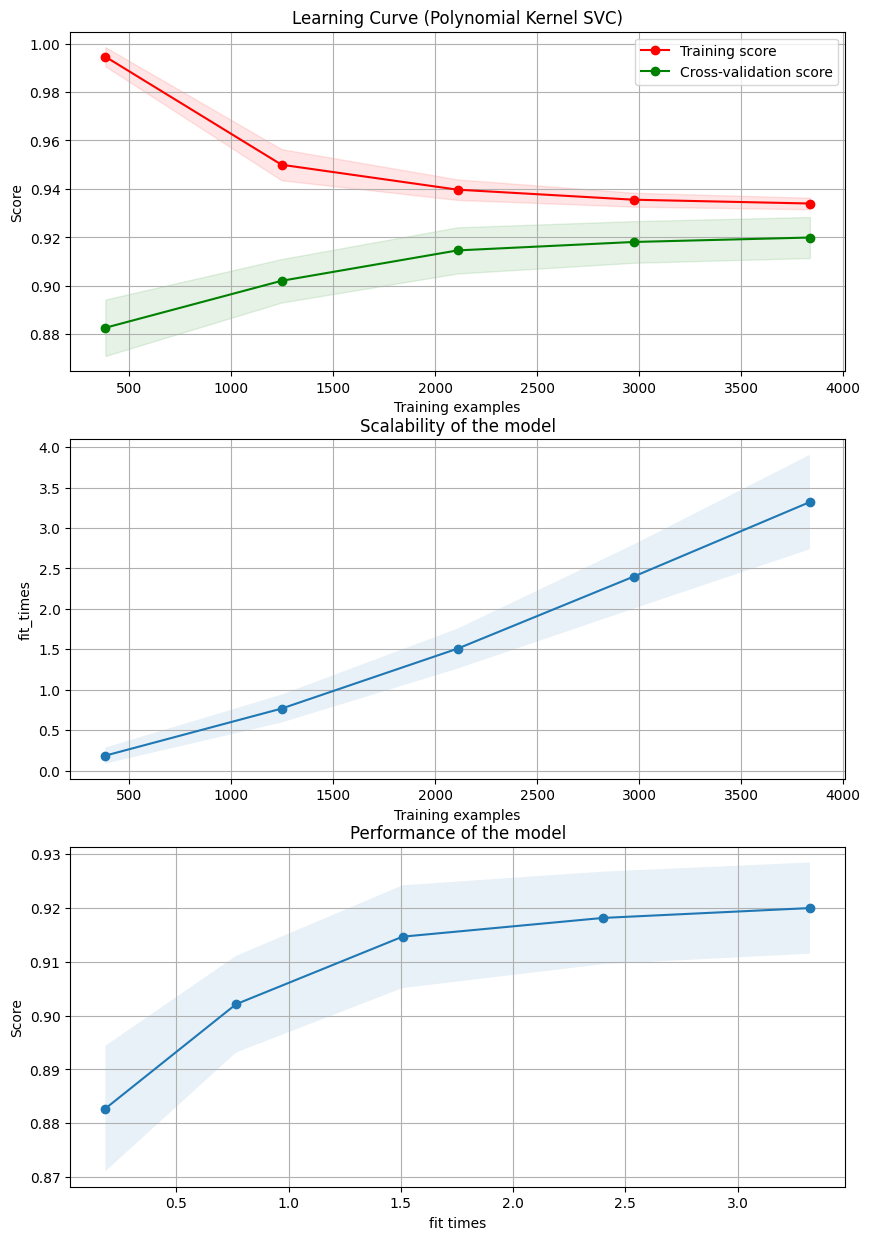

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for Random Forests algo
title = "Learning Curve for Random Forests for Face Shape Detection"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(rmf, title, features_train, labels_train, axes=axes, 
                    ylim=(0.7, 1.01), cv = cv)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(labels_test, y_pred, normalize = False, title = None):
    conf_matrix = confusion_matrix(labels_test, y_pred)
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_matrix, cmap='Blues')
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    if title:
        plt.title(title)

    plt.xticks([0, 1], ['0 (Negative)', '1 (Positive)'])
    plt.yticks([0, 1], ['0 (Negative)', '1 (Positive)'])

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, round(conf_matrix[i, j], 4),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.show()

In [ ]:
plot_confusion_matrix(labels_test, y_pred, normalize=True, title = 'Random Forests Face Shape')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
def plot_ROC_curve(model, features_test, labels_test, title = None):

    # predict the scores of the positive class
    y_scores = model.decision_function(features_test)

    # calculate the false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(labels_test, y_scores)

    # calculate the AUC
    auc = roc_auc_score(labels_test, y_scores)
    
    # plot the ROC curve
    if title:
        plt.title(title)
        
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_ROC_curve(rmf, features_test, labels_test, title = 'ROC curve for Random Forest model on Face Shape Detection dataset')